# Evrişimli Sinir Ağları Uygulama (Convolutional Neural Network Exercises)

## Google Colab - Google Drive Bağlantısının Yapılması

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Evrişimli Sinir Ağları (CNN) ile Katı Atık Tespiti

1) İş Problemi (Business Problem)

2) Veriyi Anlamak (Data Understanding)

3) Veriyi Hazırlamak (Data Preparation)

4) Modelleme (Modeling)

5) Değerlendirme (Evaluation)

# 1) İş Problemi (Business Problem)

# 2) Veriyi Anlamak (Data Understanding)

## Veri Seti Hikayesi (Dataset Story)

Bu projed kapsamında kullanacağımız veri seti TrashNet isimli veri setidir. Stanaford Üniversitesi öğrencileri tarafından hazırlanmıştır. Veri seti altı farklı sınıftan oluşmaktadır. Veri setinde Cam, Kağıt, Karton, Plastik, Metal ve Çöp olmak üzere toplamda 2527 adet görüntü bulunmaktadır.


Görüntülerin dağılımı:

- 501 cam (glasses)
- 594 kağıt (paper)
- 403 karton (cardboard)
- 482 platik (plastic)
- 410 metal (metal)
- 137 çöp (trash)


Görüntüler beyaz bir panoya yerleştirilerek ve güneş ışığı veya oda aydınlatması kullanılarak çekilmiştir. Görüntüler, 512x384 piksel boyutlarında ve 3(RGB) kanallıdır.
- Veri seti hakkında daha fazla bilgi için GitHub sayasını ziyaret edebilirsiniz.
- Veri seti indirmek için Kaggle sayfasını ziyaret edebilirsiniz.

## 2.1) Gerekli  Kütüphanelerin Import İşlemleri

In [ ]:
# pip install imutils

#  Veriyi okuma ve işleme adımında kullanılacak olan kütüphaneler
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Warningleri kapatmak için kullanılmaktadır.
import warnings
warnings.filterwarnings('ignore')

#Model için kullanılacak olan kütüphaneler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [ ]:
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 2.2) Veri Setinin Okunması



1.   Google Colab Notebook ile Google Drive hesabının eşleştirilmesi.
2.   Veri setinin Google Drive'a yüklenmesi ve adresin notebook'a gösterilmesi
3.   Veri setini okuyacak fonksiyonun tanımlanması.



In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Drive'da bu veri setinde yer alan görüntülerin olduğu path bilgisinin tutulması
dir_path = '/content/drive/MyDrive/Garbage_classification'

In [ ]:
# Target size ve Label Etiket Değerlerinin Belirlenmesi

target_size = (224, 224)

waste_labels = {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [ ]:
def load_datasets(path):
  """
  Görsellerin bulunduğu dizindeki görüntüyü okuyup etiketleri oluşturur.

  Parametreler:

  path: Görsellerin bulunduğu dizini ifade eder.

  Return:
  
  x: Görüntülere ait olduğu sınıf bilgisini tutan liste.

  """
  
  x = []
  labels = []

  # Gönderdiğimiz pathdeki görüntüleri listeleyip sıralamaktadır.
  image_paths = sorted(list(paths.list_images(path)))

  for image_path in image_paths:
    # Belirtilen pathdeki görüntüler openCV kütüphanesi ile okunmaktadır.
    img = cv2.imread(image_path)

    # Okunan görüntüler başlangıçta belirlenen target_size'a göre yeniden ölçeklendirilir.
    img = cv2.resize(img, target_size)

    # Ölçeklendirilen görüntüler x listesine eklenir.
    x.append(img)

    # Her bir path '/' ifadesi ile ayrıldığında dönen listenin sondan ikinci elemanı labelı temsil etmektedir.
    label = image_path.split(os.path.sep)[-2]

    # Yakalanan labelların sayısal değer karşılıklarının olduğu waste_labels sözlüğü içerisinden gönderilen key
    # değerine karşılık gelen value değeri alınarak label oluşturulur.
    labels.append(waste_labels[label])

    # Veri seti random bir şekilde karıştırılır.
    x, labels = shuffle(x, labels, random_state = 42)

    # Boyut ve sınıf bilgisi raporlanmaktadır.
  print(f"X boyutu: {np.array(x).shape}")
  print(f"Label sınıf sayısı: {len(np.unique(labels))} Gözlem sayısı: {len(labels)}")

  return x, labels

In [ ]:
x, labels = load_datasets(dir_path)

X boyutu: (2527, 224, 224, 3)
Label sınıf sayısı: 6 Gözlem sayısı: 2527


In [ ]:
# Görüntü boyutlarının tutulması
input_shape = (np.array(x[0]).shape[1],np.array(x[0]).shape[1], 3)
print(input_shape)

(224, 224, 3)


## 2.3) Veri Setinden Örnekler Gösterilmesi

In [ ]:
def visualize_img(image_batch, label_batch):
  """
  Veri seti içerisinden görüntü görselleştirilir.

  Parametreler:

  image_batch: Görüntülere ait martris bilgilerini tutar.

  label_batch: Görüntünün ait olduğu sınıf bilgisini tutan liste.

  """
  plt.figure(figsize=(10, 10))
  for n in range(10):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=6)[n]==1][0].title())
    plt.axis('off')

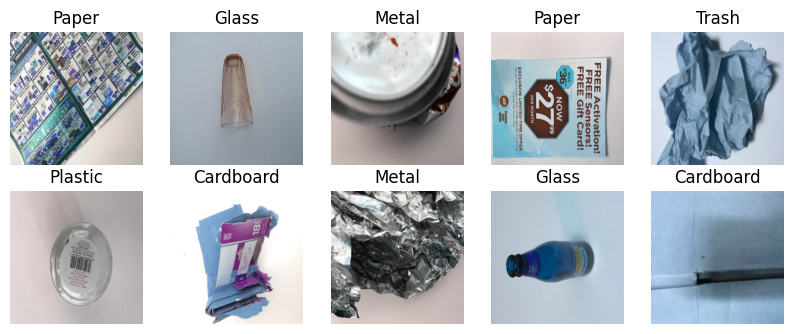

In [ ]:
visualize_img(x, labels)

# 3 Veriyi Hazırlamak (Data Preparation)

In [ ]:
# Train veri seti için bir generator tanımlıyoruz.
train = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.1,
                           rescale=1./255,
                           shear_range = 0.1,
                           zoom_range = 0.1,
                           width_shift_range= 0.1,
                           height_shift_range = 0.1)

# Test veri seti için bir generator tanımlıyoruz.
test = ImageDataGenerator(rescale=1/255,
                          validation_split=0.1)

In [ ]:
train_generator=train.flow_from_directory(directory=dir_path,
                                          target_size=(target_size),
                                          class_mode='categorical',
                                          subset='training')

test_generator=test.flow_from_directory(directory=dir_path,
                                        target_size=(target_size),
                                        batch_size=251,
                                        class_mode='categorical',
                                        subset='validation')

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


# 4) Modelleme (Modeling)

## 4.1) Sıfırdan CNN Modeli Kurma

- Sequential
- Evrişim Katmanı(Convolotion Layer,Conv2D)
- Havuzlama Katmanı (Pooling Layer)
- Aktivasyon Fonksiyonu Katmanı (Activation Layer)
- Flattening Katmanı
- Dense Katmanı
- Dropout Katmanı

In [ ]:
model=Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(input_shape), activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', input_shape=(input_shape), activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(input_shape), activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=6, activation='softmax'))

## 4.2) Model Özeti

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0

## 4.3) Optimizasyon ve Değerlendirme Metriklerinin Ayarlanması

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode="min"),
             
             ModelCheckpoint(filepath='mymodel.h5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False, verbose=1)]

## 4.4) Modelin Eğitilmesi

In [ ]:
history = model.fit_generator(generator=train_generator,
                              epochs=15,
                              validation_data=test_generator,
                              callbacks=callbacks,
                              workers=4,
                              steps_per_epoch=2276//32,
                              validation_steps=251//32)

Epoch 1/15
71/71 [==============================] - ETA: 0s - loss: 1.7382 - precision: 0.5000 - recall: 0.0027 - acc: 0.2317
Epoch 1: val_loss improved from inf to 1.60892, saving model to mymodel.h5
71/71 [==============================] - 63s 657ms/step - loss: 1.7382 - precision: 0.5000 - recall: 0.0027 - acc: 0.2317 - val_loss: 1.6089 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.3426
Epoch 2/15
71/71 [==============================] - ETA: 0s - loss: 1.5870 - precision: 0.6111 - recall: 0.0588 - acc: 0.3249
Epoch 2: val_loss improved from 1.60892 to 1.52238, saving model to mymodel.h5
71/71 [==============================] - 53s 720ms/step - loss: 1.5870 - precision: 0.6111 - recall: 0.0588 - acc: 0.3249 - val_loss: 1.5224 - val_precision: 0.6579 - val_recall: 0.0996 - val_acc: 0.3825
Epoch 3/15
71/71 [==============================] - ETA: 0s - loss: 1.5526 - precision: 0.6345 - recall: 0.0967 - acc: 0.3498
Epoch 3: val_loss improved from 1.52238 to 1.52204, 

## 4.5) Accuracy ve Loss Grafikleri

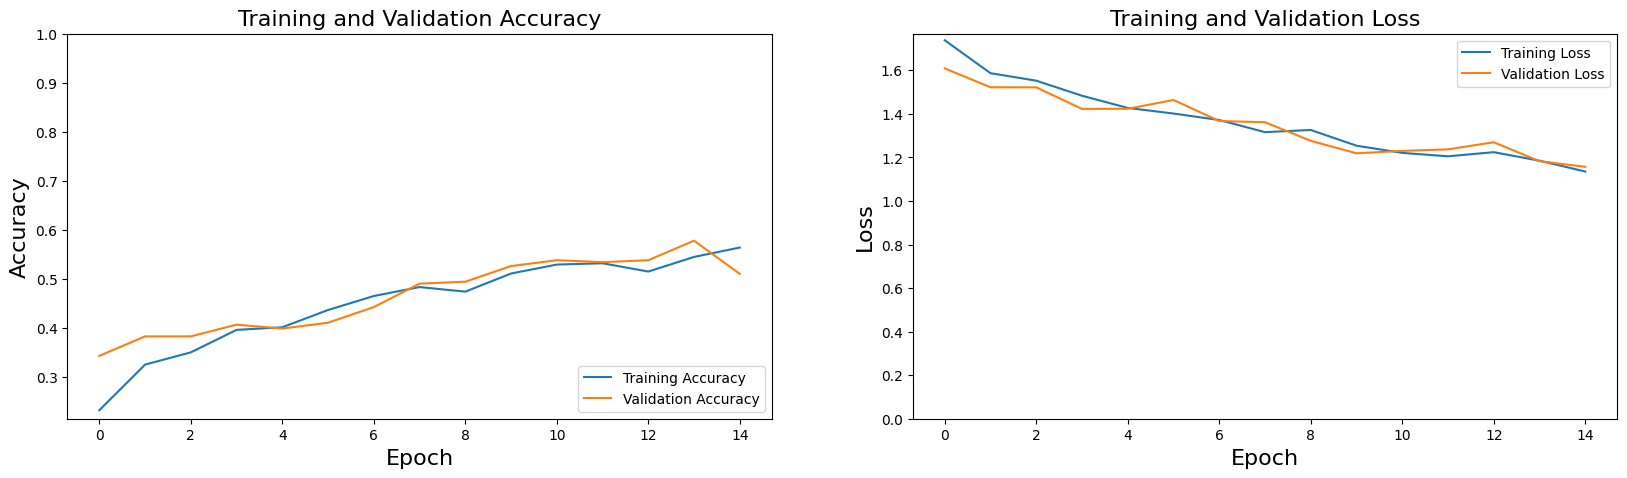

In [ ]:
# Accuracy Grafiği

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label ='Training Accuracy')
plt.plot(history.history['val_acc'], label ='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy', fontsize=16)


# Loss Grafiği

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label ='Training Loss')
plt.plot(history.history['val_loss'], label ='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

# 5) Değerlendirme (Evaluation)

In [ ]:
loss, precision, recall, acc = model.evaluate(test_generator, batch_size=32)
print("\nTest Accuracy: %.1f%%" % (100.0 * acc))
print("\nTest Loss: %.1f%%" % (100.0 * loss))
print("\nTest Precision: %.1f%%" % (100.0 * precision))
print("\nTest Recall: %.1f%%" % (100.0 * recall))

1/1 [==============================] - 4s 4s/step - loss: 1.1570 - precision: 0.7768 - recall: 0.3466 - acc: 0.5100

Test Accuracy: 51.0%

Test Loss: 115.7%

Test Precision: 77.7%

Test Recall: 34.7%


In [ ]:
# Classification Report
x_test, y_test = test_generator.next()

y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test, axis=1)

y_pred

8/8 [==============================] - 1s 92ms/step


array([1, 1, 0, 3, 1, 2, 1, 3, 0, 0, 3, 1, 1, 0, 1, 3, 1, 2, 1, 2, 1, 3,
       3, 1, 1, 1, 3, 0, 1, 1, 1, 4, 1, 4, 1, 3, 4, 4, 3, 1, 0, 3, 1, 0,
       2, 4, 0, 0, 2, 1, 3, 4, 0, 4, 1, 1, 1, 1, 2, 3, 2, 3, 1, 3, 0, 1,
       0, 3, 0, 0, 1, 4, 3, 2, 0, 3, 3, 2, 3, 3, 1, 1, 2, 2, 1, 1, 1, 3,
       2, 0, 1, 3, 2, 4, 3, 1, 2, 3, 1, 3, 5, 2, 3, 3, 2, 3, 3, 2, 4, 1,
       2, 0, 3, 2, 1, 0, 3, 3, 3, 3, 0, 3, 0, 1, 4, 2, 3, 0, 0, 4, 0, 4,
       1, 1, 0, 0, 0, 4, 3, 2, 1, 4, 1, 1, 1, 3, 1, 0, 1, 1, 3, 3, 0, 1,
       0, 3, 1, 1, 1, 3, 3, 2, 3, 4, 3, 2, 3, 4, 3, 3, 3, 1, 2, 0, 1, 1,
       3, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 4, 3, 2, 1, 3, 3, 1, 1, 3, 0, 1,
       1, 4, 0, 3, 4, 1, 1, 4, 1, 4, 3, 0, 3, 0, 3, 3, 3, 3, 0, 1, 1, 2,
       1, 2, 1, 1, 0, 2, 3, 3, 1, 1, 1, 4, 2, 3, 1, 3, 2, 1, 2, 0, 1, 1,
       3, 3, 3, 1, 1, 4, 2, 2, 3])

In [ ]:
target_names = list(waste_labels.keys())

In [ ]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   cardboard       0.74      0.70      0.72        40
       glass       0.34      0.58      0.43        50
       metal       0.42      0.34      0.38        41
       paper       0.64      0.76      0.70        59
     plastic       0.50      0.25      0.33        48
       trash       0.00      0.00      0.00        13

    accuracy                           0.51       251
   macro avg       0.44      0.44      0.43       251
weighted avg       0.50      0.51      0.49       251



In [ ]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(8,6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True Label', fontweight="bold")
  plt.xlabel('Predict Label', fontweight="bold")

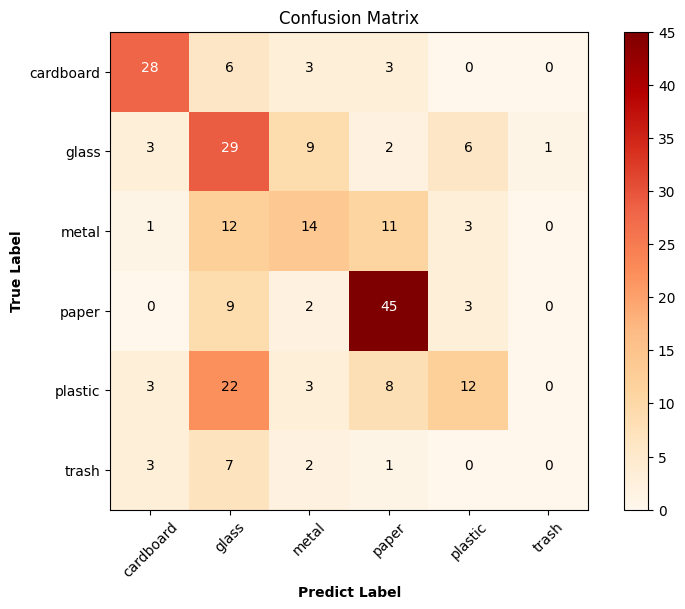

In [ ]:
plot_confusion_matrix(cm, waste_labels.keys(),
                      title='Confusion Matrix',
                      cmap=plt.cm.OrRd)

# Modelin Kullanılması / Test Edilmesi

In [ ]:
waste_labels = {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [ ]:
def model_testing(path):
  """
  Görsellerin bulunduğu dizindeki görüntüyü okuyup model aracılığı ile hangi sınıfa ait olduğuna dair tahmin işlemi gerçekleştirilir.
  
  Parametreler:

  path: Görsellerin bulunduğu dizini ifade eder.

  Return:

  img: Görüntü

  p: Tahmin olasılıkları

  predicted_class: Tahmin sınıfı

  """

  img = image.load_img(path, target_size=(target_size))
  img = image.img_to_array(img, dtype=np.uint8)
  img=np.array(img)/255.0
  p=model.predict(img.reshape(1, 224, 224, 3))
  predicted_class = np.argmax(p[0])

  return img, p, predicted_class

1/1 [==============================] - 0s 117ms/step


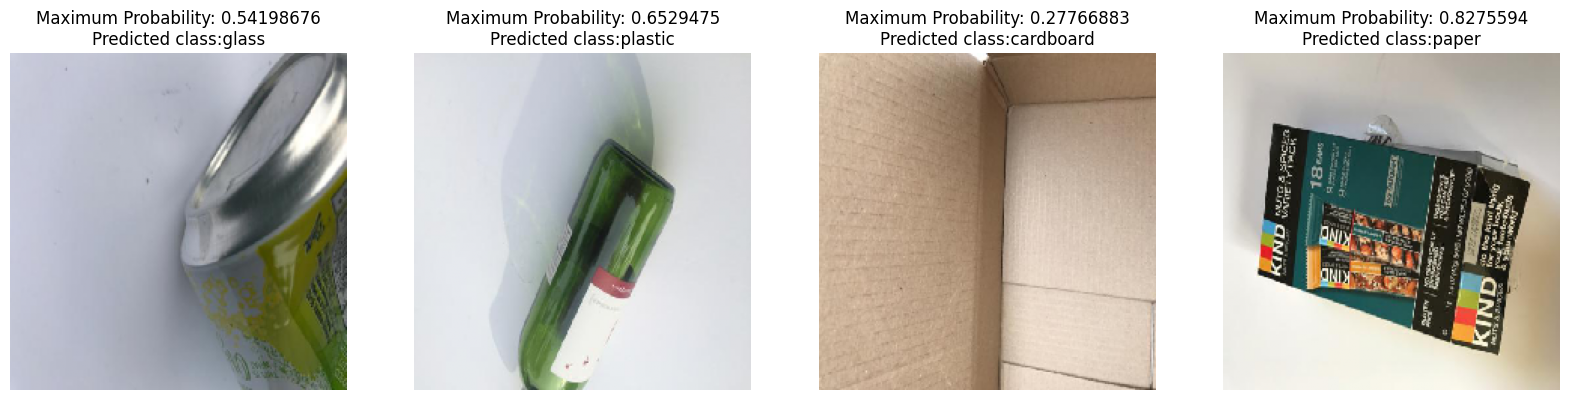

In [ ]:
img1, p1, predicted_class1 = model_testing('/content/drive/MyDrive/Garbage_classification/metal/metal10.jpg')
img2, p2, predicted_class2 = model_testing('/content/drive/MyDrive/Garbage_classification/glass/glass105.jpg')
img3, p3, predicted_class3 = model_testing('/content/drive/MyDrive/Garbage_classification/cardboard/cardboard103.jpg')
img4, p4, predicted_class4 = model_testing('/content/drive/MyDrive/Garbage_classification/paper/paper106.jpg')

plt.figure(figsize=(20,60))

plt.subplot(141)
plt.axis('off')
plt.imshow(img1.squeeze())
plt.title("Maximum Probability: " + str(np.max(p1[0], axis = 0)) + "\n" + "Predicted class:" + str(waste_labels[predicted_class1]))
plt.imshow(img1);

plt.subplot(142)
plt.axis('off')
plt.imshow(img2.squeeze())
plt.title("Maximum Probability: " + str(np.max(p2[0], axis = 0)) + "\n" + "Predicted class:" + str(waste_labels[predicted_class2]))
plt.imshow(img2);

plt.subplot(143)
plt.axis('off')
plt.imshow(img3.squeeze())
plt.title("Maximum Probability: " + str(np.max(p3[0], axis = 0)) + "\n" + "Predicted class:" + str(waste_labels[predicted_class3]))
plt.imshow(img3);

plt.subplot(144)
plt.axis('off')
plt.imshow(img4.squeeze())
plt.title("Maximum Probability: " + str(np.max(p4[0], axis = 0)) + "\n" + "Predicted class:" + str(waste_labels[predicted_class4]))
plt.imshow(img4);